# Using structural connections to build common spaces
This cell contains the name of the title that will be linked from the previous page 
This notebook or markdown file depending on how you want to do this Shaun is the chapter space for your material


In [22]:
import os
data_dir=os.path.realpath('../../data/03-warrington/')
print(f'data for this chapter is stored in the {data_dir}')
### copy any pngs in the data folder to this notebook folder 
!mkdir -p images
!cp {data_dir}/*png images/

data for this chapter is stored in the /Users/shaunwarrington/Library/CloudStorage/OneDrive-TheUniversityofNottingham/Deliverables/Conferences_Talks/OHBM24/HBMtalk/code/CrossSpeciesNeuroIntro/data/03-warrington


Overview:
Diffusion tractography allows for the reconstruction of major white matter fibre bundles, many of which are preserved across evolution and show cortical connectivity patterns common and/or divergent across species. These (dis)similarities may be probed to understand brain evolution. In this talk, I will introduce how we can build common spaces anchored on major white matter fibre bundles to quantitatively compare brains across evolution.

### Key references:

First principles of whole-brain cross-species comparisons using connectivity blueprints:

- Mars R., Sotiropoulos S.N., Passingham R.E., Sallet J., Verhagen L., Khrapitchev A.A., Sibson N., Jbabdi S. (2018) Whole brain comparative anatomy using connectivity blueprints. eLife. DOI: 10.7554/eLife.35237

Description of XTRACT and the associated protocols:

- Warrington S., Bryant K., Khrapitchev A., Sallet J., Charquero-Ballester M., Douaud G., Jbabdi S., Mars R., Sotiropoulos S.N. (2020) XTRACT - Standardised protocols for automated tractography in the human and macaque brain. NeuroImage. DOI: 10.1016/j.neuroimage.2020.116923

First concurrent mapping of brain ontogeny and phylogeny (and source of the data used in this notebook):

- Warrington S., Thompson E., Bastiani M., Dubois J., Baxter L., Slater R., Jbabdi S., Mars R.B., Sotiropoulos S.N. (2022) Concurrent mapping of brain ontogeny and phylogeny within a common space: Standardzed tractography and applications. Science Advances, 8(42). DOI: 10.1126/sciadv.abq2022


The functions in this tutorial have been formalised and released as a part of FSL (XTRACT, xtract_blueprint and xtract_divergence).
FSL documentation for XTRACT can be found here: https://fsl.fmrib.ox.ac.uk/fsl/docs/#/diffusion/xtract.
The XTRACT source code (including xtract_blueprint and xtract_divergence for building and comparing connectivity blueprints) is available here: https://github.com/SPMIC-UoN/xtract.
The data used in this tutortial are from Warrington et al. (2022) Sci. Adv.


Shaun Warrington (and the work presented in this notebook) is supported by funding from the ERC (ERC Consolidator grant: 101000969).

In [19]:
import numpy as np # 1.26.4
import matplotlib.pyplot as plt # 3.9.0
import seaborn as sns # 0.13.2
import nibabel as nib # 5.2.1
from nibabel import cifti2
from surfplot import Plot # https://pypi.org/project/surfplot 0.2.0

import os, time, warnings
warnings.simplefilter("ignore", UserWarning)

In [3]:
## Some useful functions to handle and process data.

# get useful CIFTI info and store in easy to reach places
def get_info(bp):
    bp_info = bp.header.get_axis(1)
    bp_info.tracts = [i[0] for i in bp.header.get_axis(0)]
    bp_info.cii_type = [i[0] for i in bp_info[:]]
    bp_info.cii_coord = [i[1] for i in bp_info[:]]
    bp_info.cii_structure = [i[2] for i in bp_info[:]]
    bp_info.nvert = bp_info.cii_type.count('CIFTI_MODEL_TYPE_SURFACE')
    bp_info.nvert_l = bp_info.cii_structure.count('CIFTI_STRUCTURE_CORTEX_LEFT')
    bp_info.nvert_r = bp_info.cii_structure.count('CIFTI_STRUCTURE_CORTEX_RIGHT')
    bp_info.nvox = bp_info.cii_type.count('CIFTI_MODEL_TYPE_VOXELS')
    return bp_info

# load gifti surfaces and stack
def load_surf(pathL, pathR):
    surf = nib.load(pathL).agg_data()
    surf = np.transpose(surf)
    grot = nib.load(pathR).agg_data()
    grot = np.transpose(grot)
    surf = np.concatenate((surf, grot))
    return surf

# Kullback-Leibler divergence
def KLD(A, B):
    A = A+10**-6
    B = B+10**-6
    with np.errstate(divide='ignore'):
        A = A / np.sum(A, axis=1, keepdims=True)
        B = B / np.sum(B, axis=1, keepdims=True)
    A[np.isnan(A)] = 0
    B[np.isnan(B)] = 0
    Amask = A!=0
    Bmask = B!=0
    with np.errstate(divide='ignore'):
        D = np.dot(A*np.log2(A+(A==0)), Bmask.T) - np.dot(A, (Bmask*np.log2(B+(B==0))).T) + np.dot(Amask, (B*np.log2(B+(B==0))).T) - np.dot((Amask*np.log2(A+(A==0))), B.T)
    return D

# single greyordinate to whole-brain divergence
def div_singleGO(bp1, bp2, template_cii, mask, outname=None, measure='KLD', coord=None):
    if coord is not None:
        bp1 = bp1[:, coord].reshape(-1, 1)
    else:
        bp1 = bp1.reshape(-1, 1)
    
    print('Calculating KL divergence for ROI')
    D = KLD(bp1.T, bp2.T)
    D[:, mask == 0] = 0
    if outname is not None:
        ax_0 = nib.cifti2.ScalarAxis(['KLD'])
        ax_1 = template_cii.header.get_axis(1)
        new_h = nib.cifti2.Cifti2Header.from_axes((ax_0, ax_1))
        cii_new = nib.cifti2.Cifti2Image(D, new_h)
        nib.save(cii_new, outname)
    return D

# whole-brain dense divergence matrix
def div_wholebrain(bp1, bp2, template_cii, mask):
    os.environ["PYTHONWARNINGS"] = "ignore"
    start = time.time()
    print('Calculating KL divergence for whole-brain... this takes a moment')
    D = KLD(bp1.T, bp2.T)
    D[:, mask == 0] = 0
    end = time.time()
    print(f'Time taken: {end - start:.2f}s')
    os.environ["PYTHONWARNINGS"] = "default"
    return D

# use divergence matrix as warp field to predict scalar map
def predict_map(D, source_map, gamma=-4):
    with np.errstate(divide='ignore'):
        W = np.power(D, gamma)
        W[np.where(np.isinf(W))] = 0
        W[np.where(np.isnan(W))] = 0
        pred = np.dot(W/np.sum(W, axis=1, keepdims=True), source_map.reshape(-1))
    return pred


## The data...

Connectivity bluepints contain a set maps of tract termination in the cortex. Each column is a tract. Each row of the blueprint describes how a given cortical location connects to the tracts of interest. This is exampled in the image below with examples of the human, macaque and neonate brains.

<img src="images/blueprint_schematic.png" width="400" height="380">

We have pre-baked blueprints for the human and macaque brain. They contain 41 tracts each (as will be printed out). For a description of these tracts, see: https://fsl.fmrib.ox.ac.uk/fsl/docs/#/diffusion/xtract?id=xtract-tracts and https://www.sciencedirect.com/science/article/pii/S1053811920304092. The blueprints are averages across 50 unrelated subjects from the young-adult Human Connectome Project (HCP) (Van Essen et al., 2013, Neuroimage) and six high-quality post-mortem macaque brains (availbale from PRIMatE Data Exchange: PRIME-DE, http://fcon_1000.projects.nitrc.org/indi/PRIME/oxford2.html)

These blueprints are at a low resolution (approx. 2k vertices per hemisphere) for quick processing, and contain only cortical surface data. Note: the latest xtract_blueprint can create blueprints including the subcortex.

In [11]:
results_dir=os.path.join(data_dir, 'results')

# e.g. human blueprint - group average derived from the young-adult Human Connectome Project (HCP)
# note: blueprints are at 2k vertices per hemisphere for quick processing
bpa = nib.load(os.path.join(data_dir, 'ave_hum_2k.BP.dscalar.nii'))
bpafull = bpa.get_fdata(dtype=np.float32)
bpa_info = get_info(bpa)
a_nvert_l = int(bpa_info.nvert/2)

# e.g. macaque blueprint - group average across 6 post-mortem macaque brains (fcon_1000.projects.nitrc.org/indi/PRIME/oxford2.html)
bpb = nib.load(os.path.join(data_dir, 'ave_mac_2k.BP.dscalar.nii'))
bpbfull = bpb.get_fdata(dtype=np.float32)
bpb_info = get_info(bpb)
b_nvert_l = int(bpb_info.nvert/2)

# load medial wall masks
maska = load_surf(os.path.join(data_dir, 'hum_atlasroi.2k.L.shape.gii'), os.path.join(data_dir, 'hum_atlasroi.2k.R.shape.gii'))
maskb = load_surf(os.path.join(data_dir, 'mac_atlasroi.2k.L.shape.gii'), os.path.join(data_dir, 'mac_atlasroi.2k.R.shape.gii'))
maska = np.concatenate((maska, np.ones(bpa_info.nvox)))
maskb = np.concatenate((maskb, np.ones(bpb_info.nvox)))

tract_list = bpa_info.tracts

print(f'\nUsing {len(tract_list)} tracts:')
print(*tract_list, sep =', ')


Using 41 tracts:
af_l, af_r, ar_l, ar_r, atr_l, atr_r, cbd_l, cbd_r, cbp_l, cbp_r, cbt_l, cbt_r, cst_l, cst_r, fa_l, fa_r, fma, fmi, fx_l, fx_r, ilf_l, ilf_r, ifo_l, ifo_r, mdlf_l, mdlf_r, or_l, or_r, str_l, str_r, slf1_l, slf1_r, slf2_l, slf2_r, slf3_l, slf3_r, ac, uf_l, uf_r, vof_l, vof_r


## Visualise the blueprints

Here, we use python library surplot to display an example tract on the cortical surface for the human and macaque brain. We use the example of the third branch of the superior longitudinal fasciculus (SLF3). You can change the tract (check the output from the cell about for tract names) to explore how different tracts look in each species. Brighter regions indicate regions of greater likelihood of connectivity to the given tract.

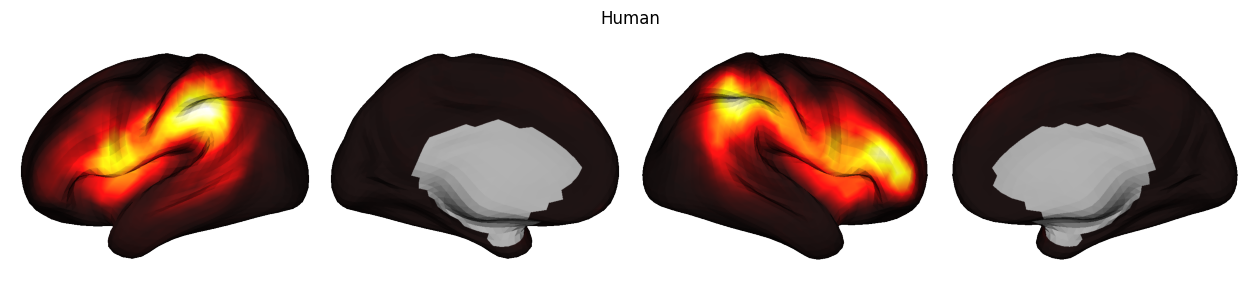

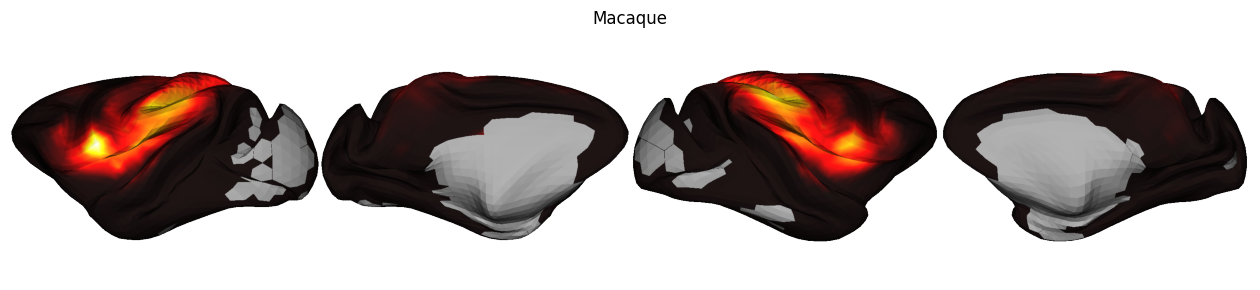

In [12]:
# e.g. with SLF 3
# note: blueprints are low res!
t_l = 'slf3_l'
t_r = 'slf3_r'

# plot the human blueprint
p = Plot(os.path.join(data_dir, 'L.rhum.inflated.2k.surf.gii'), os.path.join(data_dir, 'R.rhum.inflated.2k.surf.gii'), layout='row', size=(1500, 300))
p.add_layer({'left': bpafull[tract_list.index(t_l), :a_nvert_l], 'right': bpafull[tract_list.index(t_r), a_nvert_l:]}, cmap='hot', cbar=False)
fig = p.build()
plt.title('Human')
fig.show()

# plot the macaque blueprint
p = Plot(os.path.join(data_dir, 'L.rmac.inflated.2k.surf.gii'), os.path.join(data_dir, 'R.rmac.inflated.2k.surf.gii'), layout='row', size=(1500, 300))
p.add_layer({'left': bpbfull[tract_list.index(t_l), :b_nvert_l], 'right': bpbfull[tract_list.index(t_r), b_nvert_l:]}, cmap='hot', cbar=False)
fig = p.build()
plt.title('Macaque')
fig.show()

## Calculate whole-brain divergence matrix (every vertex to every vertex)

Since our blueprints are defined using common white matter landmarks (the tracts), we can quantitatively compare them using for example, Kullback-Leibler (KL) divergence. This is a measure of distance between two probability distribution. Note: we normalise our blueprint so that each row of the blueprint sums to one, i.e. rows are probability distributions representing the likelihood of cortical locations connecting to each given tract.

Let $M$ be the group-averaged macaque connectivity blueprint matrix and $M_{ik}$ represent the likelihood of a connection from vertex $i$ on the macaque cortex to tract $k$. Let matrix $H$ be the equivalent matrix for the human brain, with the set of tracts with length $T$. Vertices $i$ and $j$ in the macaque and human brains can then be compared in terms of their connectivity patterns {$M_{ik}$, $H_{jk}$, $k=1:T$} using the symmetric KL divergence $D_{ij}$ as a dissimilarity measure. Note: prior to this calculation, we shift (add a small positive constant) group-averaged connectivity blueprints to avoid zeros.

$$D_{ij} = \sum_{k} M_{ik} \log_2 \frac{M_{ik}}{H_{jk}} + \sum_{k} H_{jk} \log_2 \frac{H_{jk}}{M_{ik}}$$

First, we will calculate a dense KL divergence matrix, i.e. $D_{ij}$. Here, for every vertex in the macaque brain $i$, we calculate the divergence to every vertex in the human brain $j$. Lower (darker with the default sns.heatmap colour map) values correspond to lower divergence, i.e. greater similarity. Although the vertices are not ordered in the exact same way across species, they roughly follow a similar layout, hence we observe some diagonal in the resultant matrix.

Calculating KL divergence for whole-brain... this takes a moment
Time taken: 0.18s


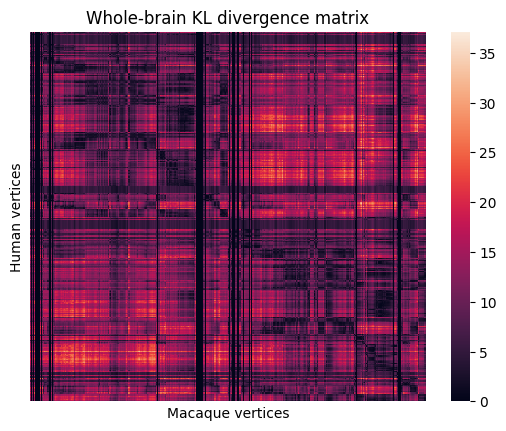

In [23]:
div = div_wholebrain(bpbfull, bpafull, bpa, maska)

fig = sns.heatmap(div, xticklabels=False, yticklabels=False)
plt.title('Whole-brain KL divergence matrix');
plt.xlabel('Macaque vertices');
plt.ylabel('Human vertices');

## Predict cortical regions across brains.

Using KL divergence, we can predict regions of equivlance across brains. Since functional regions are bound by their anatomical connections, we expect that regions with similar anatomical connections should be corresponding in function. Using KL divergence, we can find regions that are most similar across brains. We example this by taking the average connectivity fingerprint for a given cortical region (sensorymotor region, and the MT+ region) in the human brain and we find vertices with the best matching connectivity fingerprints in the macaque brain. To do that, we simply find the KL divergence between the average human fingerprint and the whole brain of the macaque. This gives us a brain-wide divergence map in the macaque brain. By applying an arbritary threshold to this map, we can obtain a prediction of the equivlanet cortical region in the macaque brain.

### Steps:
- Get the average fingerprint of a human cortical region (e.g. M1+S1/sensory-motor and MT plus regions)
- Find the divergence from the average fingerprint in the human ROI to the whole of the macaque brain
- Lower (more purple in the maps below) divergence indicates regions more similar to the human ROI
- Apply threshold to make prediction

In [14]:
def ROI_pred(roi, roi_mac, bpafull, bpbfull, bpb, maskb, threshold):
    # load base ROI (the human ROI)
    roi_img = nib.load(roi)
    roi_img = roi_img.darrays[0].data
    roi_name = os.path.basename(roi).replace('.shape.gii', '')
    
    # reduce the blueprint to the left hemisphere
    temp_bpa_roi = bpafull[:, :a_nvert_l]

    # take the average in the ROI
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        temp_bpa_roi = np.mean(temp_bpa_roi[:, roi_img == 1], axis=1)

    # get the divergence to the whole macaque brain
    D = div_singleGO(temp_bpa_roi, bpbfull, bpb, maskb)
    
    # save file out
    foutname = os.path.join(results_dir, f'{roi_name}.dscalar.nii')
    D[:, maskb == 0] = 0
    ax_0 = nib.cifti2.ScalarAxis(['KLD'])
    ax_1 = bpb.header.get_axis(1)
    new_h = nib.cifti2.Cifti2Header.from_axes((ax_0, ax_1))
    cii_new = nib.cifti2.Cifti2Image(D, new_h)
    nib.save(cii_new, foutname)

    # plot results
    # the human ROI
    p = Plot(os.path.join(data_dir, 'L.rhum.inflated.2k.surf.gii'), layout='row', size=(750, 300), views=['lateral'])
    p.add_layer({'left': roi_img}, cmap='Pastel1', cbar=False)
    fig = p.build()
    plt.title('Human ROI')
    fig.show()

    # the actual macaque ROI
    roi_img_mac = nib.load(roi_mac)
    roi_img_mac = roi_img_mac.darrays[0].data
    p = Plot(os.path.join(data_dir, 'L.rmac.inflated.2k.surf.gii'), layout='row', size=(750, 300), views=['lateral'])
    p.add_layer({'left': roi_img_mac}, cmap='Pastel1', cbar=False)
    fig = p.build()
    plt.title('Actual macaque ROI')
    fig.show()

    # the divergence map
    p = Plot(os.path.join(data_dir, 'L.rmac.inflated.2k.surf.gii'), layout='row', size=(750, 300), views=['lateral'])
    p.add_layer({'left': D[0,:b_nvert_l]}, cmap='cool_r', cbar=True, color_range=[1, 3], cbar_label='KL divergence')
    fig = p.build()
    plt.title('Divergence map')
    fig.show()

    # the ROI prediction (just binarising the KL divergence map)
    D[D < threshold] = 1
    D[D > threshold] = 0
    p = Plot(os.path.join(data_dir, 'L.rmac.inflated.2k.surf.gii'), layout='row', size=(750, 300), views=['lateral'])
    p.add_layer({'left': D[0,:b_nvert_l]}, cmap='Pastel1', cbar=False)
    fig = p.build()
    plt.title('Predicted ROI')
    fig.show()

First, we apply the prediction to a region which we know to be relatively similar across brains. The sensory-motor region (specifically M1+S1 regions from the Glasser parcellation).

We compare the prediction to the M1+S1 from the Paxions parcellation.

This comparison acts as a nice sanity check. We know that sensory fingerprints and these cortical regions should be relatively consistent so we expect a reasonably good prediction.

Calculating KL divergence for ROI


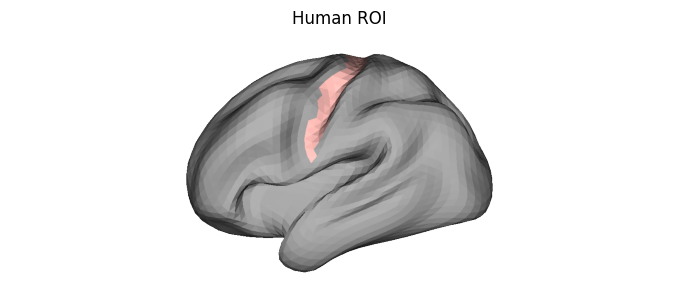

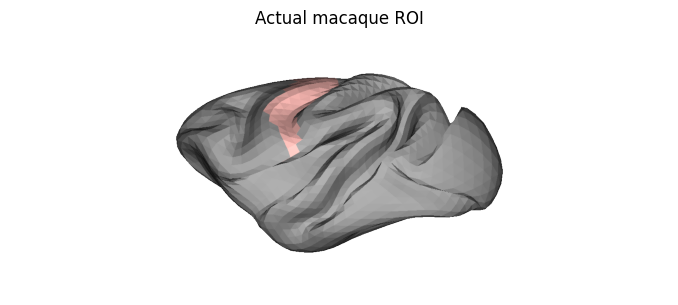

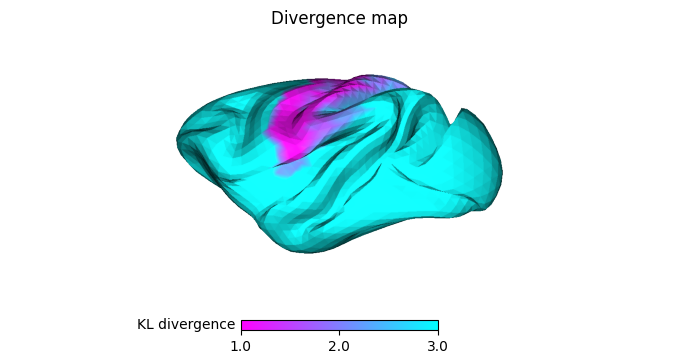

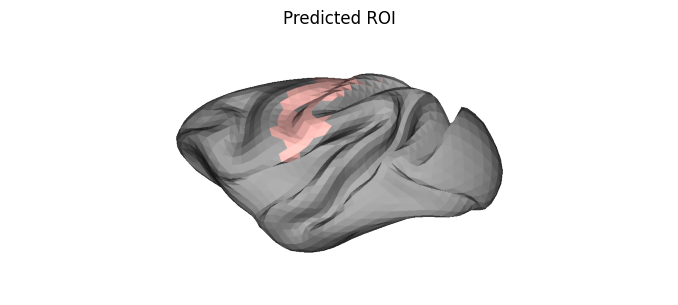

In [15]:
ROI_pred(os.path.join(data_dir, 'hum_sensory_motor.2k.L.shape.gii'), os.path.join(data_dir, 'mac_sensory_motor.2k.L.shape.gii'), 
         bpafull, bpbfull, bpb, maskb, threshold=2)

Next, we apply the prediction to a region known to differ significantly across brains.

The MT+ is a small ROI in the human temporal-parietal region

In the macaque, the MT+ is expanded

Our prediction re-captualtes this difference. Based on connectivity fingerprints alone, we can predict ROIs across brains, even in cases where those ROIs are significantly different!

Calculating KL divergence for ROI


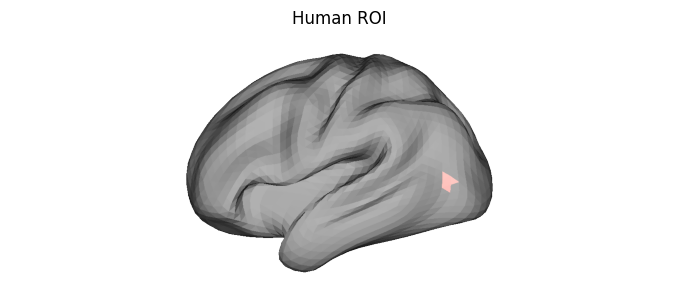

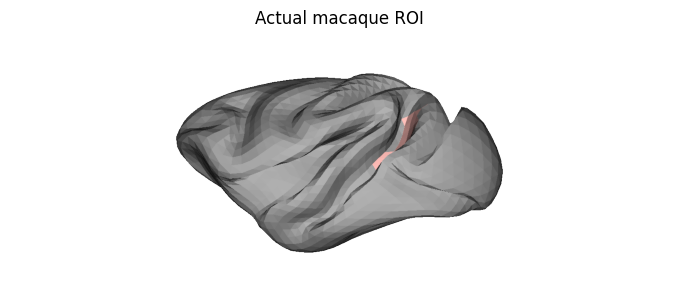

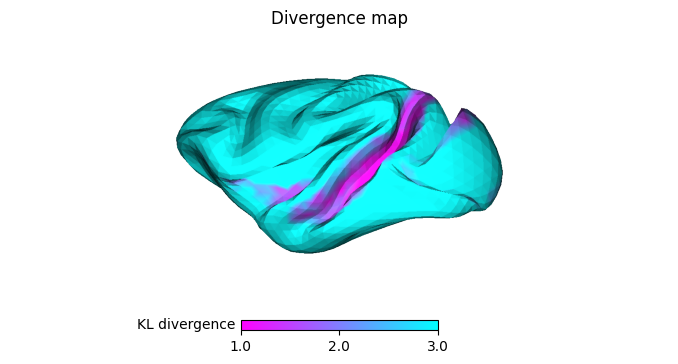

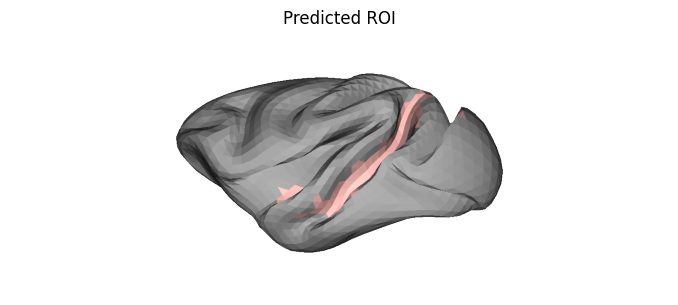

In [16]:
ROI_pred(os.path.join(data_dir, 'hum_MTplus.2k.L.shape.gii'), os.path.join(data_dir, 'mac_MTplus.2k.L.shape.gii'), 
         bpafull, bpbfull, bpb, maskb, threshold=2)

## Translate a cortical map across brains

We can also use divergence as a metric to translate cortical scalar maps. In essence, we use the similarity (the inverse of the divergence) as a warp field. Given a human scalar map $h_i$ and outhe calculated KL divergence matrix $D_{ji}$ matrix, we can calculate the a macaque map $m_j$ as:

$$m_j = \frac{\sum D^{\gamma}_{ji} h_i}{\sum D^{\gamma}_{ji}}$$


We example this here using a map of cortical myelination. Using divergence between the human and macaque connectivity blueprints and the equation above, we translate the human myelin map to the macaque cortex. We then compare the predicted map to the measured map below and find strong correspondence. Of particular note, is the expansion of the highly myelinated region in the visual/occipital cortex in the macaque brain.

### Steps:
- Calculate whole-brain (dense) KL divergence
- Use the inverse of this (i.e. similarity) as a ward field to translate the human myelin map to the macaque brain
- Compare actual and predicted myelin maps

Calculating KL divergence for whole-brain... this takes a moment
Time taken: 0.06s


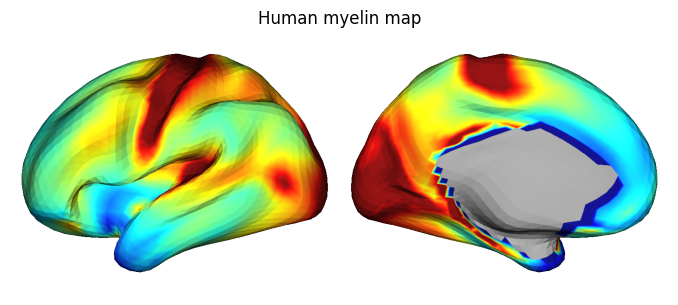

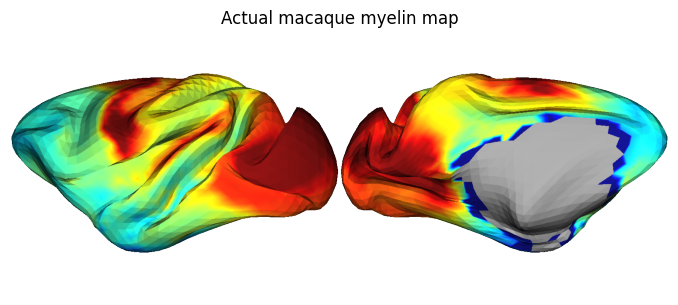

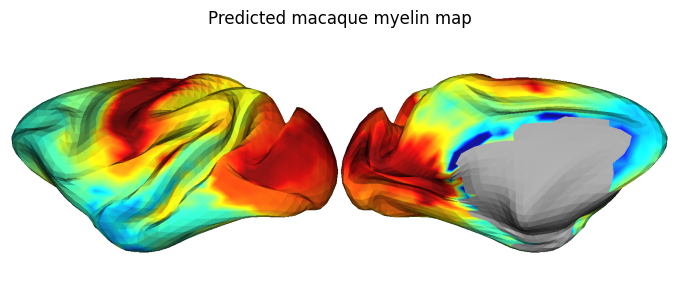

In [24]:
## predict myelin map
# load myelin maps (left only for speed)
mac_myelin = nib.load(os.path.join(data_dir, 'mac_myelin.2k.L.func.gii'))
mac_myelin_img = mac_myelin.agg_data()
hum_myelin = nib.load(os.path.join(data_dir, 'hum_myelin.2k.L.func.gii')).agg_data()

# get KL divergence
div = div_wholebrain(bpbfull[:, :b_nvert_l], bpafull[:, :a_nvert_l], bpa, maskb[:b_nvert_l])

# predict map
mac_myelin_pred = predict_map(div, hum_myelin)

# null medial wall (in calculating KLD, we fill the empty medial wall vertices. Need to undo that filling here.)
tempmask = maskb[:b_nvert_l]
mac_myelin_pred[tempmask == 0] = 0

# save - replace the data in the original myelin map GIFTI object and save using same header info
mac_myelin.darrays[0] = nib.gifti.gifti.GiftiDataArray(data=mac_myelin_pred)
nib.save(mac_myelin, os.path.join(results_dir, 'mac_myelin_prediction.2k.L.func.gii'))

## plot the results
# the measured human myelin map
p = Plot(os.path.join(data_dir, 'L.rhum.inflated.2k.surf.gii'), layout='row', size=(750, 300), views=['lateral', 'medial'])
p.add_layer({'left': hum_myelin}, cmap='jet', cbar=False, color_range=[1, 1.5])
fig = p.build()
plt.title('Human myelin map')
fig.show()

# the measured macaque myelin map
p = Plot(os.path.join(data_dir, 'L.rmac.inflated.2k.surf.gii'), layout='row', size=(750, 300), views=['lateral', 'medial'])
p.add_layer({'left': mac_myelin_img}, cmap='jet', cbar=False, color_range=[1, 1.5])
fig = p.build()
plt.title('Actual macaque myelin map')
fig.show()

# the predicted macaque myelin map
p = Plot(os.path.join(data_dir, 'L.rmac.inflated.2k.surf.gii'), layout='row', size=(750, 300), views=['lateral', 'medial'])
p.add_layer({'left': mac_myelin_pred}, cmap='jet', cbar=False, color_range=[1, 1.5])
fig = p.build()
plt.title('Predicted macaque myelin map')
fig.show()